In [ ]:
import os
import shutil
import time
from google.colab import drive


if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')


zip_shortcut_path = '/content/drive/MyDrive/Universal_Dataset_Zipped.zip'
local_extract_path = '/content/Universal_Final_Dataset'


if not os.path.exists(zip_shortcut_path):
    print(f"❌ ERROR: Cannot find the file at: {zip_shortcut_path}")
    print("👉 Check your Drive: Did you name the shortcut EXACTLY 'Universal_Dataset_Zipped.zip'?")
else:
    print(f"🚀 Found Zip File! Copying to local SSD...")

    shutil.copy(zip_shortcut_path, '/content/dataset.zip')

    print("📦 Unzipping... (This takes ~30 seconds)")

    os.makedirs(local_extract_path, exist_ok=True)

    !unzip -q /content/dataset.zip -d /content/Universal_Final_Dataset

    print("✅ DONE! Dataset is ready for training.")


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {device}")


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


TRAIN_DIR = f'{local_extract_path}/train'
VAL_DIR = f'{local_extract_path}/val'
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0005
NUM_CLASSES = 7


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


print("\n📂 Loading Data Loaders...")
if os.path.exists(TRAIN_DIR):
    train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
    val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    print("✅ Data Loaders Created Successfully.")
else:
    print("❌ ERROR: Training folder not found. Unzip might have failed.")


print("\n🧠 Downloading EfficientNet-V2...")
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

criterion = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

SAVE_PATH = '/content/drive/MyDrive/Universal_OCT_EfficientNet_Best.pth'

print("\n🔥 Starting Training...")
start_time = time.time()

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print('-' * 15)


    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.double() / len(train_dataset)


    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)


            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)


    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f'\n📊 Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
    print(f'📊 Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}')


    if val_acc > best_acc:
        print(f"🌟 New Best Accuracy ({val_acc:.4f})! Saving to Drive...")
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), SAVE_PATH)

print(f"\n✅ Training Complete. Best Acc: {best_acc:.4f}")
print(f"💾 Model saved to: {SAVE_PATH}")

Mounted at /content/drive
🚀 Found Zip File! Copying to local SSD...
📦 Unzipping... (This takes ~30 seconds)
✅ DONE! Dataset is ready for training.
🚀 Using Device: cuda

📂 Loading Data Loaders...
✅ Data Loaders Created Successfully.

🧠 Downloading EfficientNet-V2...
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:01<00:00, 77.1MB/s]



🔥 Starting Training...

Epoch 1/15
---------------


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.19it/s]



📊 Train Loss: 0.1002 | Acc: 0.9207
📊 Val Loss:   0.0966 | Acc: 0.9182
🌟 New Best Accuracy (0.9182)! Saving to Drive...

Epoch 2/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.07it/s]



📊 Train Loss: 0.0575 | Acc: 0.9488
📊 Val Loss:   0.0868 | Acc: 0.9212
🌟 New Best Accuracy (0.9212)! Saving to Drive...

Epoch 3/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.84it/s]



📊 Train Loss: 0.0449 | Acc: 0.9573
📊 Val Loss:   0.0853 | Acc: 0.9202

Epoch 4/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.03it/s]



📊 Train Loss: 0.0395 | Acc: 0.9624
📊 Val Loss:   0.0987 | Acc: 0.9069

Epoch 5/15
---------------


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.32it/s]



📊 Train Loss: 0.0437 | Acc: 0.9600
📊 Val Loss:   0.0773 | Acc: 0.9325
🌟 New Best Accuracy (0.9325)! Saving to Drive...

Epoch 6/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.13it/s]



📊 Train Loss: 0.0341 | Acc: 0.9664
📊 Val Loss:   0.0627 | Acc: 0.9369
🌟 New Best Accuracy (0.9369)! Saving to Drive...

Epoch 7/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.84it/s]



📊 Train Loss: 0.0342 | Acc: 0.9652
📊 Val Loss:   0.0627 | Acc: 0.9320

Epoch 8/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.08it/s]



📊 Train Loss: 0.0299 | Acc: 0.9688
📊 Val Loss:   0.0799 | Acc: 0.9271

Epoch 9/15
---------------


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.22it/s]



📊 Train Loss: 0.0289 | Acc: 0.9705
📊 Val Loss:   0.0816 | Acc: 0.9158

Epoch 10/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  9.08it/s]



📊 Train Loss: 0.0267 | Acc: 0.9728
📊 Val Loss:   0.0680 | Acc: 0.9236

Epoch 11/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.84it/s]



📊 Train Loss: 0.0265 | Acc: 0.9727
📊 Val Loss:   0.0589 | Acc: 0.9429
🌟 New Best Accuracy (0.9429)! Saving to Drive...

Epoch 12/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.70it/s]



📊 Train Loss: 0.0235 | Acc: 0.9753
📊 Val Loss:   0.0613 | Acc: 0.9365

Epoch 13/15
---------------


Validating: 100%|██████████| 64/64 [00:07<00:00,  8.95it/s]



📊 Train Loss: 0.0230 | Acc: 0.9753
📊 Val Loss:   0.0564 | Acc: 0.9414

Epoch 14/15
---------------


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.21it/s]



📊 Train Loss: 0.0214 | Acc: 0.9776
📊 Val Loss:   0.0654 | Acc: 0.9335

Epoch 15/15
---------------


Validating: 100%|██████████| 64/64 [00:06<00:00,  9.25it/s]


📊 Train Loss: 0.0221 | Acc: 0.9777
📊 Val Loss:   0.0671 | Acc: 0.9369

✅ Training Complete. Best Acc: 0.9429
💾 Model saved to: /content/drive/MyDrive/Universal_OCT_EfficientNet_Best.pth


📂 Loading Test Dataset...
🧠 Loading the 94.29% EfficientNet Model...
🔥 Administering Final Exam...


Testing: 100%|██████████| 64/64 [00:07<00:00,  8.57it/s]



📊 FINAL EFFICIENTNET CLASSIFICATION REPORT
              precision    recall  f1-score   support

         CNV       0.95      0.92      0.93       500
         CSR       1.00      1.00      1.00        10
         DME       0.98      0.95      0.96       500
          DR       0.91      1.00      0.95        10
      DRUSEN       0.91      0.93      0.92       500
          MH       1.00      0.90      0.95        10
      NORMAL       0.93      0.98      0.96       500

    accuracy                           0.94      2030
   macro avg       0.96      0.95      0.95      2030
weighted avg       0.94      0.94      0.94      2030



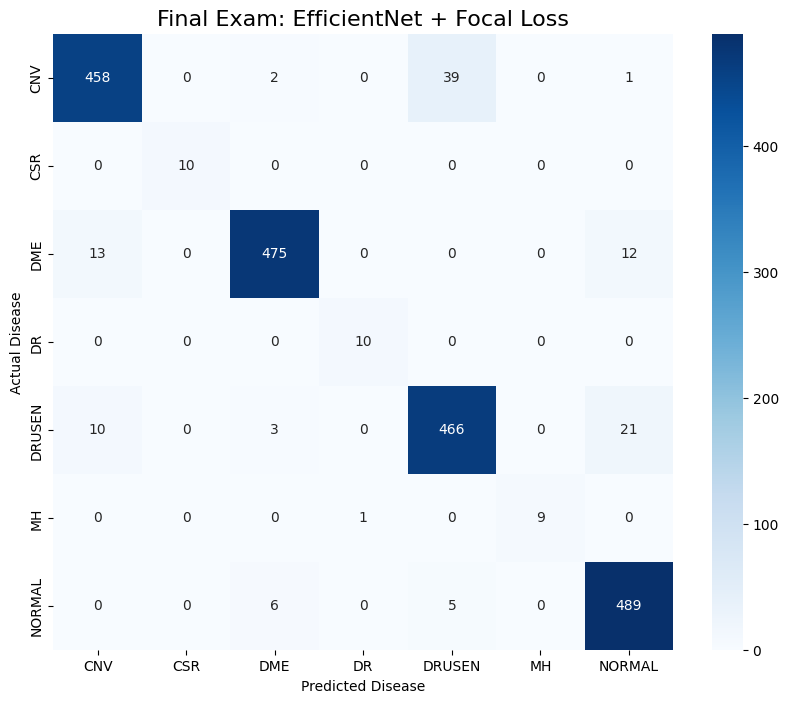

In [ ]:

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DIR = '/content/Universal_Final_Dataset/test'
MODEL_PATH = '/content/drive/MyDrive/Universal_OCT_EfficientNet_Best.pth'
NUM_CLASSES = 7


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("📂 Loading Test Dataset...")
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
class_names = test_dataset.classes


print("🧠 Loading the 94.29% EfficientNet Model...")
model = models.efficientnet_v2_s(weights=None)

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)


model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()


all_preds = []
all_labels = []

print("🔥 Administering Final Exam...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("\n" + "="*50)
print("📊 FINAL EFFICIENTNET CLASSIFICATION REPORT")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Exam: EfficientNet + Focal Loss', fontsize=16)
plt.ylabel('Actual Disease')
plt.xlabel('Predicted Disease')
plt.show()

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DIR = '/content/Universal_Final_Dataset/test'
MODEL_PATH = '/content/drive/MyDrive/Universal_OCT_EfficientNet_Best.pth'
NUM_CLASSES = 7
BATCH_SIZE = 32


t_std = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


t_hflip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0), #
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


t_vflip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


t_rot_neg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: transforms.functional.rotate(x, angle=-10)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

t_rot_pos = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: transforms.functional.rotate(x, angle=10)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


print("📂 Preparing 5-View TTA Loaders...")
ds_std = datasets.ImageFolder(TEST_DIR, transform=t_std)
ds_h = datasets.ImageFolder(TEST_DIR, transform=t_hflip)
ds_v = datasets.ImageFolder(TEST_DIR, transform=t_vflip)
ds_rn = datasets.ImageFolder(TEST_DIR, transform=t_rot_neg)
ds_rp = datasets.ImageFolder(TEST_DIR, transform=t_rot_pos)


ld_std = DataLoader(ds_std, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
ld_h = DataLoader(ds_h, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
ld_v = DataLoader(ds_v, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
ld_rn = DataLoader(ds_rn, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
ld_rp = DataLoader(ds_rp, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = ds_std.classes

print("🧠 Loading 94.29% Model...")
model = models.efficientnet_v2_s(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()


all_preds = []
all_labels = []

print("🔥 Running 5-Way TTA Voting...")


with torch.no_grad():
    for (i_std, lbl), (i_h, _), (i_v, _), (i_rn, _), (i_rp, _) in tqdm(zip(ld_std, ld_h, ld_v, ld_rn, ld_rp), total=len(ld_std)):


        i_std, i_h, i_v = i_std.to(device), i_h.to(device), i_v.to(device)
        i_rn, i_rp = i_rn.to(device), i_rp.to(device)


        o_std = model(i_std)
        o_h = model(i_h)
        o_v = model(i_v)
        o_rn = model(i_rn)
        o_rp = model(i_rp)


        p_std = F.softmax(o_std, dim=1)
        p_h = F.softmax(o_h, dim=1)
        p_v = F.softmax(o_v, dim=1)
        p_rn = F.softmax(o_rn, dim=1)
        p_rp = F.softmax(o_rp, dim=1)


        avg_prob = (p_std + p_h + p_v + p_rn + p_rp) / 5.0


        _, preds = torch.max(avg_prob, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbl.numpy())


print("\n" + "="*50)
print("🚀 FINAL 5-VIEW TTA RESULTS")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names))

acc = accuracy_score(all_labels, all_preds)
print(f"🏆 Final TTA Accuracy: {acc:.4f}")

📂 Preparing 5-View TTA Loaders...
🧠 Loading 94.29% Model...
🔥 Running 5-Way TTA Voting...


100%|██████████| 64/64 [00:45<00:00,  1.41it/s]



🚀 FINAL 5-VIEW TTA RESULTS
              precision    recall  f1-score   support

         CNV       0.95      0.93      0.94       500
         CSR       1.00      1.00      1.00        10
         DME       0.98      0.95      0.96       500
          DR       1.00      1.00      1.00        10
      DRUSEN       0.94      0.92      0.93       500
          MH       1.00      1.00      1.00        10
      NORMAL       0.92      0.99      0.95       500

    accuracy                           0.95      2030
   macro avg       0.97      0.97      0.97      2030
weighted avg       0.95      0.95      0.95      2030

🏆 Final TTA Accuracy: 0.9473


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DIR = '/content/Universal_Final_Dataset/test'
MODEL_PATH = '/content/drive/MyDrive/Universal_OCT_EfficientNet_Best.pth'
NUM_CLASSES = 7


transform_standard = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_hflip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


transform_vflip = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


print("📂 Preparing TTA Views...")
ds_standard = datasets.ImageFolder(TEST_DIR, transform=transform_standard)
ds_hflip = datasets.ImageFolder(TEST_DIR, transform=transform_hflip)
ds_vflip = datasets.ImageFolder(TEST_DIR, transform=transform_vflip)

loader_standard = DataLoader(ds_standard, batch_size=32, shuffle=False, num_workers=2)
loader_hflip = DataLoader(ds_hflip, batch_size=32, shuffle=False, num_workers=2)
loader_vflip = DataLoader(ds_vflip, batch_size=32, shuffle=False, num_workers=2)

class_names = ds_standard.classes


print("🧠 Loading Model...")
model = models.efficientnet_v2_s(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()


all_preds = []
all_labels = []

print("🔥 Running 3-Way TTA Voting...")


with torch.no_grad():
    for (img_std, lbl), (img_h, _), (img_v, _) in tqdm(zip(loader_standard, loader_hflip, loader_vflip), total=len(loader_standard)):
        img_std, img_h, img_v = img_std.to(device), img_h.to(device), img_v.to(device)


        out_std = model(img_std)
        out_h = model(img_h)
        out_v = model(img_v)


        prob_std = F.softmax(out_std, dim=1)
        prob_h = F.softmax(out_h, dim=1)
        prob_v = F.softmax(out_v, dim=1)


        avg_prob = (prob_std + prob_h + prob_v) / 3.0


        _, preds = torch.max(avg_prob, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbl.numpy())


print("\n" + "="*50)
print("🚀 FINAL TTA BOOSTED RESULTS")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names))

acc = accuracy_score(all_labels, all_preds)
print(f"🏆 TTA Accuracy: {acc:.4f}")

📂 Preparing TTA Views...
🧠 Loading Model...
🔥 Running 3-Way TTA Voting...


100%|██████████| 64/64 [00:26<00:00,  2.45it/s]


🚀 FINAL TTA BOOSTED RESULTS
              precision    recall  f1-score   support

         CNV       0.95      0.92      0.93       500
         CSR       1.00      1.00      1.00        10
         DME       0.99      0.94      0.96       500
          DR       1.00      1.00      1.00        10
      DRUSEN       0.92      0.93      0.93       500
          MH       1.00      1.00      1.00        10
      NORMAL       0.93      0.99      0.96       500

    accuracy                           0.95      2030
   macro avg       0.97      0.97      0.97      2030
weighted avg       0.95      0.95      0.95      2030

🏆 TTA Accuracy: 0.9468


🧠 Loading EfficientNet-V2...
🔥 Generating X-Ray Heatmaps (3 Samples)...


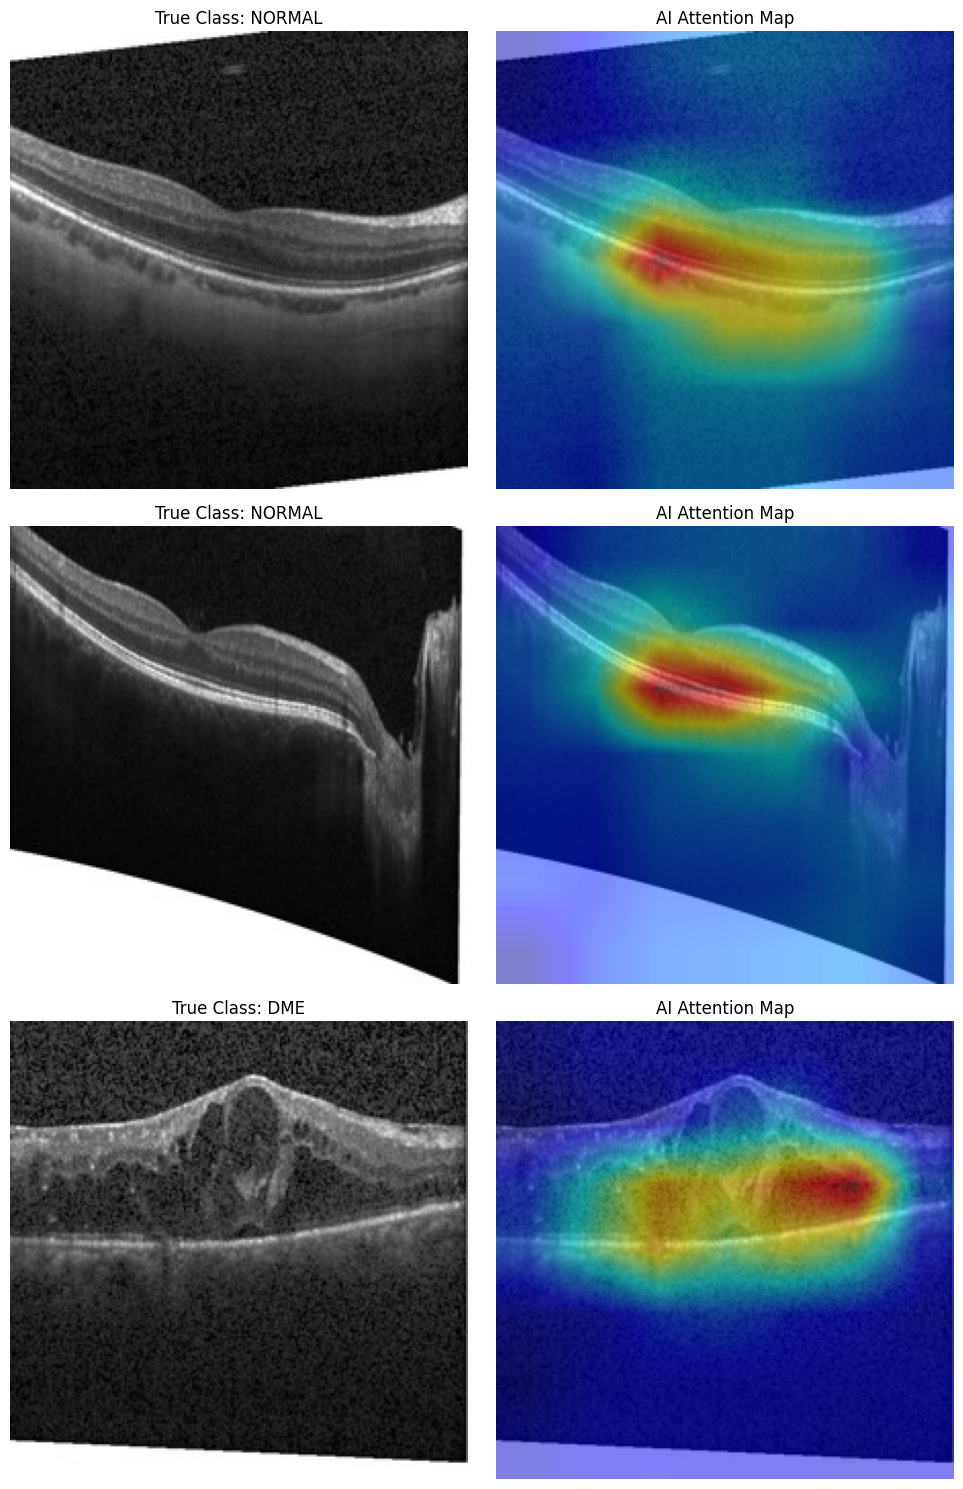

In [ ]:

import torch
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DIR = '/content/Universal_Final_Dataset/test'
MODEL_PATH = '/content/drive/MyDrive/Universal_OCT_EfficientNet_Best.pth'


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None


        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):

        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):

        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)


        self.model.zero_grad()
        output[0, class_idx].backward()


        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]


        weights = np.mean(gradients, axis=(1, 2))


        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]


        cam = np.maximum(cam, 0)


        if np.max(cam) > 0:
            cam = cam / np.max(cam)
        else:
            cam = np.zeros_like(cam)

        return cam

print("🧠 Loading EfficientNet-V2...")
model = models.efficientnet_v2_s(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 7)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()


target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
class_names = dataset.classes


print("🔥 Generating X-Ray Heatmaps (3 Samples)...")
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


indices = random.sample(range(len(dataset)), 3)

for i, idx in enumerate(indices):
    img_tensor, label = dataset[idx]
    img_tensor = img_tensor.unsqueeze(0).to(device)


    heatmap = grad_cam(img_tensor)


    img_display = img_tensor.cpu().squeeze().permute(1, 2, 0).numpy()

    img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_display = np.clip(img_display, 0, 1)


    heatmap = cv2.resize(heatmap, (224, 224))


    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


    superimposed = np.float32(heatmap) / 255 + img_display
    superimposed = superimposed / np.max(superimposed)


    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f"True Class: {class_names[label]}")
    axes[i, 0].axis('off')


    axes[i, 1].imshow(superimposed)
    axes[i, 1].set_title(f"AI Attention Map")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()